In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
import warnings
from IPython.display import display, Image
from skimage.draw import polygon2mask

import omero.clients 
from omero.gateway import BlitzGateway


%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import random_label_cmap
from stardist.models import StarDist2D

Using TensorFlow backend.


In [2]:
    

class OMEConnect(widgets.VBox):
    
    def __init__(self):
        self.logbox = widgets.Text(description="OME loggin")
        self.pwdbox = widgets.Password(description="OME password")
        self.gobtn = widgets.Button(description="Let me in")
        self.gobtn.on_click(self.on_go_clicked)
        self.out = widgets.Output()
        super().__init__((self.logbox, self.pwdbox, self.gobtn, self.out))
        self.conn = None
        

    def on_go_clicked(self, b):
        self.out.clear_output()
        
        if self.conn is not None:
            self.conn.close()
        
        self.conn = BlitzGateway(
            self.logbox.value,
            self.pwdbox.value,
            host="localhost", port=4064)           
        self.conn.connect()
        if self.conn.isConnected():
            with self.out:
                print("Logging successful!\n")
                display(Image("https://media.giphy.com/media/Azwmdv1NTSe9W/giphy.gif"))
        else:
            with self.out:
                ("sorry, connection failed, try again?")
            self.logbox.value = ''
            self.pwdbox.value = ''


In [3]:
m = OMEConnect()

display(m)

OMEConnect(children=(Text(value='', description='OME loggin'), Password(description='OME password'), Button(de…

In [4]:
conn = m.conn

image = conn.getObject("Image", 1)
imshape = (image.getSizeX(), image.getSizeY())


roi_service = conn.getRoiService()
rois = roi_service.findByImage(image.getId(), None).rois


def mask_from_polyon_roi(roi):
    s0 = roi.getShape(0)
    points = s0.getPoints()

    points = np.array([
        [float(v) for v in l.split(',')]
         for l in points.val.split(' ')])
    points = np.concatenate([points, [points[0]]])
    return polygon2mask(imshape, points).astype(np.uint8)

labels = np.zeros(imshape)
for i, roi in enumerate(rois):
    labels += mask_from_polyon_roi(roi)*(i+1)


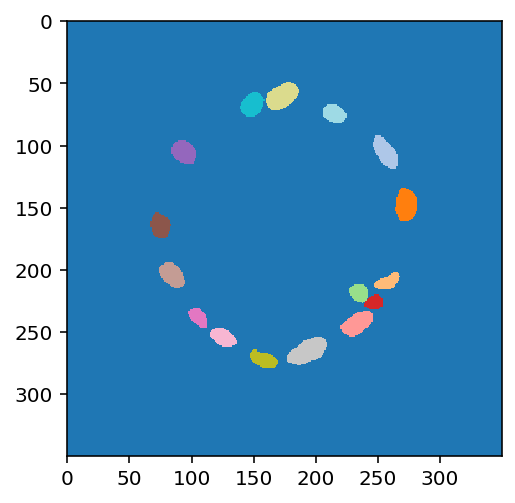

In [5]:
_ = plt.imshow(labels[250:600, 450:800], cmap="tab20")


In [7]:
model = StarDist2D(None, name='2D_demo', basedir='../../stardist/models/examples')


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.486166, nms_thresh=0.5.


In [15]:
pixels = image.getPrimaryPixels()

In [9]:
image.getChannelLabels()

['HOECHST 33342', 'Alexa 488', 'Alexa 568']

In [10]:
size_z = image.getSizeZ()

In [11]:

im_43 = pixels.getPlane(theZ=43, theC=0)

In [16]:
im_43 = normalize(im_43, 1, 99.8)
labels, details = model.predict_instances(im_43, axes="XY")

In [17]:
labels.shape

(1080, 1080)

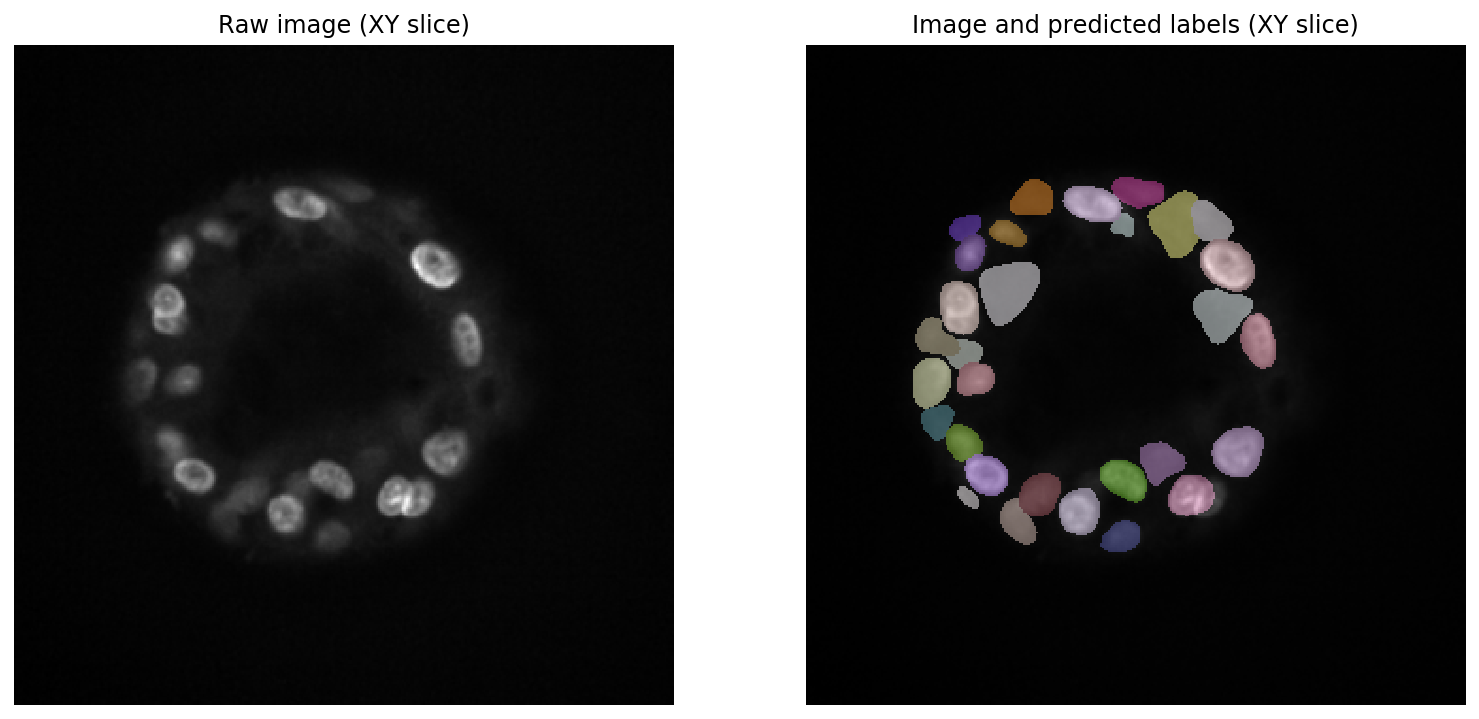

In [18]:
img = im_43


np.random.seed(6)
lbl_cmap = random_label_cmap()

plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow(img[450:800, 250:600], cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow(img[450:800, 250:600], cmap='gray')
plt.imshow(labels[250:600, 450:800].swapaxes(0, 1), cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');



In [138]:
conn.close()